In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers, models
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
tf.config.run_functions_eagerly(True)

In [76]:
# Download Fashion-MNIST
train, test = pd.read_csv('fashion-mnist_train.csv'), pd.read_csv('fashion-mnist_test.csv')

x_train, x_val, y_train, y_val = train_test_split(
    train.loc[:, train.columns!='label'], train.loc[:, train.columns=='label'], 
    test_size = 0.3, random_state= 10
)
x_test, y_test = test.loc[:, test.columns!='label'], test.loc[:, test.columns=='label']

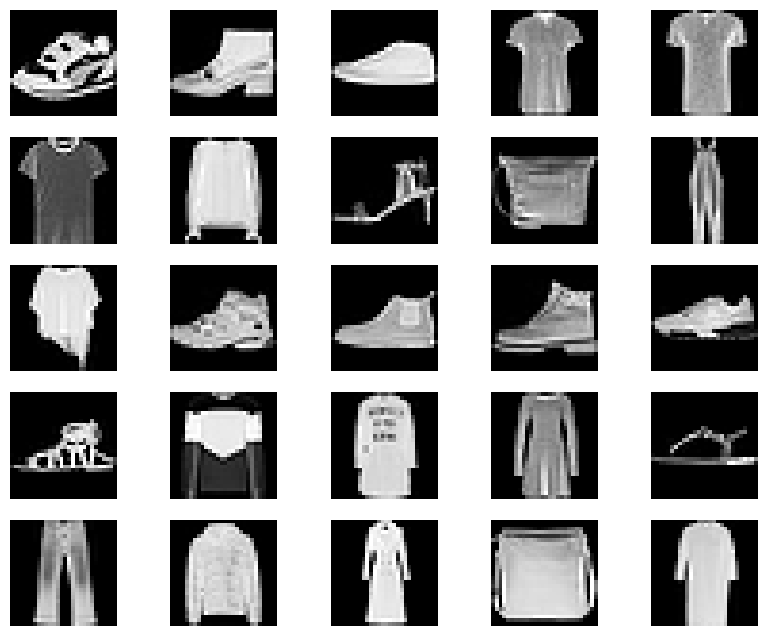

In [77]:
# Plot a data grid for general observation

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(x_train.to_numpy().reshape(-1, 28, 28, 1) ), size=(1,)).item()
    img = x_train.to_numpy().reshape(-1, 28, 28, 1) [sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [78]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [79]:
x_train_values = x_train_scaled.reshape(-1, 28, 28, 1) 
x_val_values = x_val_scaled.reshape(-1,28,28,1)
x_test_values = x_test_scaled.reshape(-1,28,28,1)

x_train_values.shape, x_val_values.shape, x_test_values.shape

((42000, 28, 28, 1), (18000, 28, 28, 1), (10000, 28, 28, 1))

In [80]:
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

y_train.shape, y_val.shape, y_test.shape

((42000, 10), (18000, 10), (10000, 10))

In [7]:
# Set the parameters of the neural network
bs_model = Sequential()

loss_function = 'categorical_crossentropy'
opt = 'adam'

In [8]:
# Create your convolutional neural network architecture

bs_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
bs_model.add(layers.MaxPooling2D((2,2)))
bs_model.add(layers.Conv2D(64, (3,3), activation='relu'))
bs_model.add(layers.MaxPooling2D((2,2)))
bs_model.add(layers.Flatten())
bs_model.add(layers.Dense(54, activation='relu'))
bs_model.add(layers.Dense(10, activation='softmax'))

In [9]:
bs_model.compile(
    optimizer = opt, 
    loss = loss_function, 
    metrics = ['accuracy']
)

In [10]:
bs_hist = bs_model.fit(x_train_values, y_train, epochs=10,
                       validation_data = (x_val_values, y_val))

Epoch 1/10
1313/1313 [==============================] - 11s 8ms/step - loss: 0.4803 - accuracy: 0.8267 - val_loss: 0.3591 - val_accuracy: 0.8703
Epoch 2/10
1313/1313 [==============================] - 11s 8ms/step - loss: 0.3230 - accuracy: 0.8831 - val_loss: 0.3500 - val_accuracy: 0.8735
Epoch 3/10
1313/1313 [==============================] - 11s 9ms/step - loss: 0.2715 - accuracy: 0.9005 - val_loss: 0.2897 - val_accuracy: 0.8939
Epoch 4/10
1313/1313 [==============================] - 11s 9ms/step - loss: 0.2351 - accuracy: 0.9139 - val_loss: 0.2835 - val_accuracy: 0.8994
Epoch 5/10
1313/1313 [==============================] - 15s 11ms/step - loss: 0.2066 - accuracy: 0.9235 - val_loss: 0.2788 - val_accuracy: 0.9025
Epoch 6/10
1313/1313 [==============================] - 15s 11ms/step - loss: 0.1845 - accuracy: 0.9314 - val_loss: 0.2755 - val_accuracy: 0.9033
Epoch 7/10
1313/1313 [==============================] - 15s 11ms/step - loss: 0.1598 - accuracy: 0.9414 - val_loss: 0.2755 - val

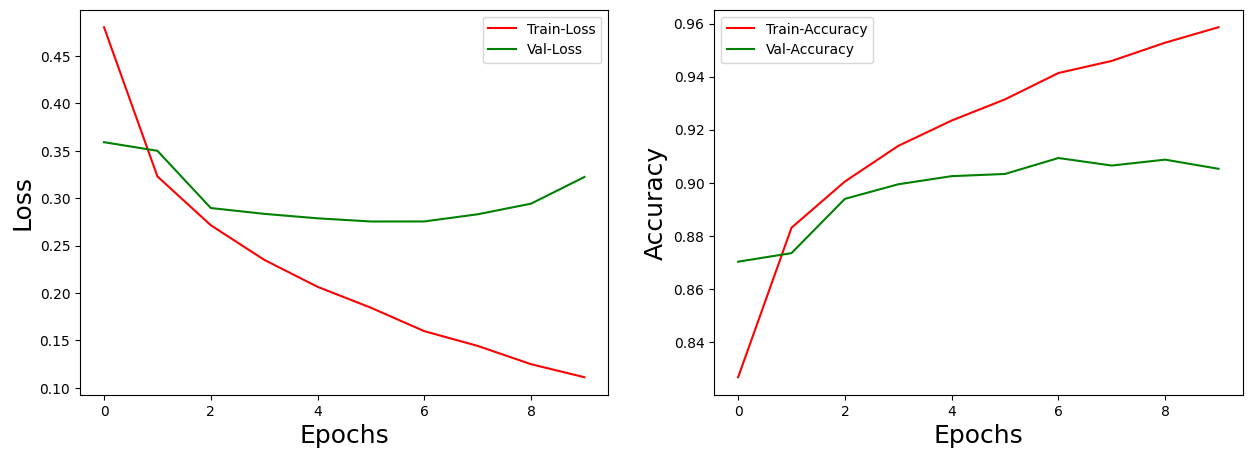

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(bs_hist.history['loss'], color='red', label='Train-Loss')
plt.plot(bs_hist.history['val_loss'], color='green', label='Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.plot(bs_hist.history['accuracy'], color='red', label='Train-Accuracy')
plt.plot(bs_hist.history['val_accuracy'], color='green', label='Val-Accuracy')
plt.legend(loc='best')
plt.show()

In [19]:
bs_hist.history['val_accuracy']

[0.8702777624130249,
 0.8734999895095825,
 0.8939444422721863,
 0.8994444608688354,
 0.9024999737739563,
 0.903333306312561,
 0.909333348274231,
 0.906499981880188,
 0.9087222218513489,
 0.9052777886390686]

In [20]:
np.max(bs_hist.history['val_accuracy'])

0.909333348274231

In [21]:
bs_hist.history['val_accuracy'].index(np.max(bs_hist.history['val_accuracy']))

6

In [22]:
bs_hist.history['accuracy'][bs_hist.history['val_accuracy'].index(np.max(bs_hist.history['val_accuracy']))]

0.9413571357727051

In [28]:
def energies_number(min, max, x_train, x_valid, y_train, y_val):
    # Select a range of min and max number of dimensions, min/max.

    acc_list, acc_val_list, pc_list = [], [], []
    for pc in range(min,max):
        bs_model = Sequential()
        loss_function = 'categorical_crossentropy'
        opt = 'adam'
        
        bs_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(pc,pc,1)))
        bs_model.add(layers.MaxPooling2D((2,2)))
        bs_model.add(layers.Conv2D(64, (3,3), activation='relu'))
        bs_model.add(layers.MaxPooling2D((2,2)))
        bs_model.add(layers.Flatten())
        bs_model.add(layers.Dense(54, activation='relu'))
        bs_model.add(layers.Dense(10, activation='softmax'))
        
        bs_model.compile(
            optimizer = opt, 
            loss = loss_function, 
            metrics = ['accuracy'])

        pca = PCA(n_components = pc**2)
        
        x_train_pca = pca.fit(x_train).transform(x_train)
        x_val_pca = pca.transform(x_valid)
        
        x_train_pca_values = x_train_pca.reshape(-1, pc, pc, 1)
        x_val_pca_values = x_val_pca.reshape(-1, pc, pc, 1)
        
        pca_hist = bs_model.fit(x_train_pca_values, y_train, epochs = 2,
                       validation_data = (x_val_pca_values, y_val))
        
        acc_val = np.max(pca_hist.history['val_accuracy'])
        acc = pca_hist.history['accuracy'][pca_hist.history['val_accuracy'].index(np.max(pca_hist.history['val_accuracy']))]
        acc_list.append(acc)
        acc_val_list.append(acc_val)
        pc_list.append(pc)
    return acc_list, acc_val_list, pc_list

In [29]:
acc_list, acc_val_list, pc_list = energies_number(10, 15, x_train_scaled, x_val_scaled, y_train, y_val)

Epoch 1/2
1313/1313 [==============================] - 3s 2ms/step - loss: 0.6710 - accuracy: 0.7703 - val_loss: 0.5501 - val_accuracy: 0.8046
Epoch 2/2
1313/1313 [==============================] - 2s 2ms/step - loss: 0.4708 - accuracy: 0.8307 - val_loss: 0.4867 - val_accuracy: 0.8302
Epoch 1/2
1313/1313 [==============================] - 3s 2ms/step - loss: 0.6713 - accuracy: 0.7662 - val_loss: 0.5009 - val_accuracy: 0.8188
Epoch 2/2
1313/1313 [==============================] - 2s 2ms/step - loss: 0.4684 - accuracy: 0.8321 - val_loss: 0.4895 - val_accuracy: 0.8173
Epoch 1/2
1313/1313 [==============================] - 3s 2ms/step - loss: 0.6764 - accuracy: 0.7666 - val_loss: 0.5162 - val_accuracy: 0.8169
Epoch 2/2
1313/1313 [==============================] - 3s 2ms/step - loss: 0.4744 - accuracy: 0.8320 - val_loss: 0.4933 - val_accuracy: 0.8217
Epoch 1/2
1313/1313 [==============================] - 3s 2ms/step - loss: 0.6699 - accuracy: 0.7673 - val_loss: 0.5002 - val_accuracy: 0.8256

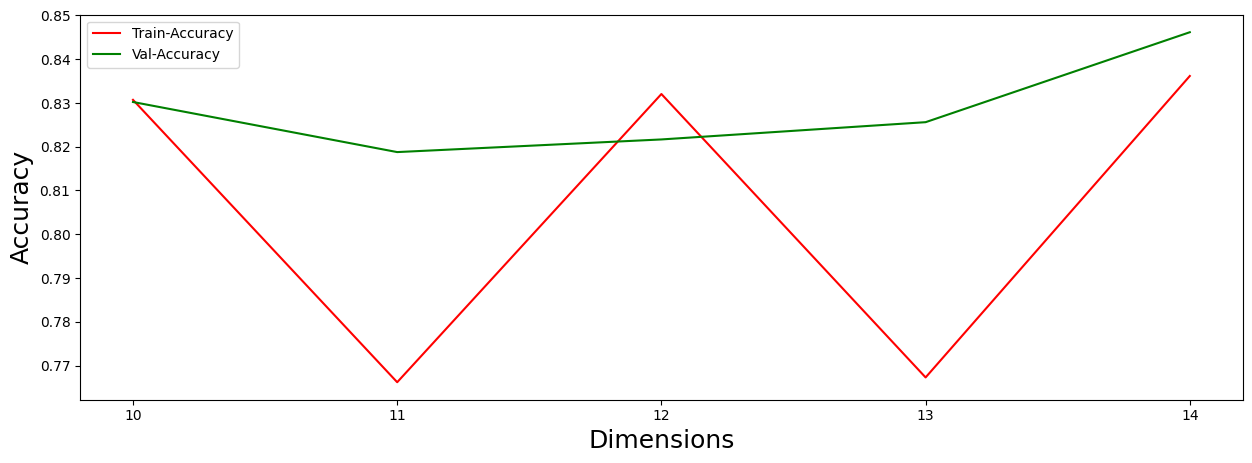

In [33]:
plt.figure(figsize=(15,5))
plt.xlabel("Dimensions", fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.plot(acc_list, color='red', label='Train-Accuracy')
plt.plot(acc_val_list, color='green', label='Val-Accuracy')
plt.legend(loc='best')
xi = list(range(len(pc_list)))
plt.xticks(xi, pc_list)
plt.show()

In [46]:
train_x = x_train / 255
test_x = x_train / 255

In [47]:
input_shape = (1, 28, 28)

x_train = train_x.reshape(train_x.shape[0], *input_shape)
x_test = test_x.reshape(test_x.shape[0], *input_shape)

x_train = torch.stack([torch.from_numpy(np.array(i)) for i in x_train])
x_test = torch.stack([torch.from_numpy(np.array(i)) for i in x_test])

train_set = torch.utils.data.TensorDataset(x_train, x_train)
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * 0.8), round(len(train_set) * 0.2)])
test_set = torch.utils.data.TensorDataset(x_test, x_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [48]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3,3))
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3))
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3))
        self.conv3 = nn.ConvTranspose2d(16, 8, kernel_size=(3,3))
        self.conv4 = nn.ConvTranspose2d(8, 1, kernel_size=(3,3))
        self.sigmoid_activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.sigmoid_activation(x)
        return x

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [64]:
from torchmetrics import Accuracy

model = Autoencoder()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.999)

# Loss function
loss_func = Accuracy()

for epoch in range(2):
    # print(f'Epoch: {epoch}')
    current_time = time.time()

    # Train
    model.train()
    loss_tr = []
    for step, (images_raw, images_out) in enumerate(train_loader):
        p = model(images_raw.float())
        batch_loss = loss_func(images_out.float(), p.int())
        loss_tr.append(batch_loss.detach().item())
        optimizer.zero_grad()
        optimizer.step()
    print(f"{epoch}, training_loss {np.mean(loss_tr)}, {time.time() - current_time} secs")
    current_time = time.time()
    
    # Validation
    model.eval()
    loss_ts = []
    for step, (images_raw, images_out) in enumerate(val_loader):
        p = model(images_raw.float())
        batch_loss = loss_func(images_out.float(), p.int())       
        loss_ts.append(batch_loss.detach().cpu().numpy())
    print(f"{epoch}, validation_loss {np.mean(loss_ts)}, {time.time() - current_time} secs")
    scheduler.step()

0, training_loss 1.0, 26.540977239608765 secs
0, validation_loss 1.0, 6.643524408340454 secs
1, training_loss 1.0, 27.119385242462158 secs
1, validation_loss 1.0, 6.758993625640869 secs


In [100]:
from keras import regularizers
encoding_dim = 32 

input_img = keras.Input(shape=(784,))

encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [101]:
encoder = keras.Model(input_img, encoded)

In [102]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [103]:
autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics='accuracy')

In [104]:
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_scaled, x_val_scaled))

Epoch 1/10
165/165 [==============================] - 3s 19ms/step - loss: -25.2315 - val_loss: -88.6191
Epoch 2/10
165/165 [==============================] - 3s 18ms/step - loss: -234.5154 - val_loss: -421.4540
Epoch 3/10
165/165 [==============================] - 3s 18ms/step - loss: -688.6143 - val_loss: -988.9966
Epoch 4/10
165/165 [==============================] - 3s 18ms/step - loss: -1370.7953 - val_loss: -1774.4053
Epoch 5/10
165/165 [==============================] - 3s 18ms/step - loss: -2270.5876 - val_loss: -2770.7302
Epoch 6/10
165/165 [==============================] - 3s 18ms/step - loss: -3375.0386 - val_loss: -3960.3342
Epoch 7/10
165/165 [==============================] - 3s 17ms/step - loss: -4667.0928 - val_loss: -5333.7451
Epoch 8/10
165/165 [==============================] - 3s 18ms/step - loss: -6150.0649 - val_loss: -6892.2202
Epoch 9/10
165/165 [==============================] - 3s 17ms/step - loss: -7801.7720 - val_loss: -8613.2988
Epoch 10/10
165/165 [======

In [122]:
x_train = np.array(x_train).reshape(-1, 28, 28, 1) / 255.0
x_val = np.array(x_val).reshape(-1, 28, 28, 1) / 255.0

import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = layers.Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = layers.Conv2D(1, (2, 2), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(2, activation='relu')(x)


x = layers.Dense(4, activation='relu')(encoded)
x = layers.Reshape((2, 2, 1))(x)
x = layers.Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((7, 7))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [124]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/5
165/165 [==============================] - 167s 1s/step - loss: 0.0569 - accuracy: 0.4982 - val_loss: 0.0775 - val_accuracy: 0.5026
Epoch 2/5
  7/165 [>.............................] - ETA: 2:19 - loss: 0.0086 - accuracy: 0.4998

KeyboardInterrupt: 

563/563 [==============================] - 6s 11ms/step


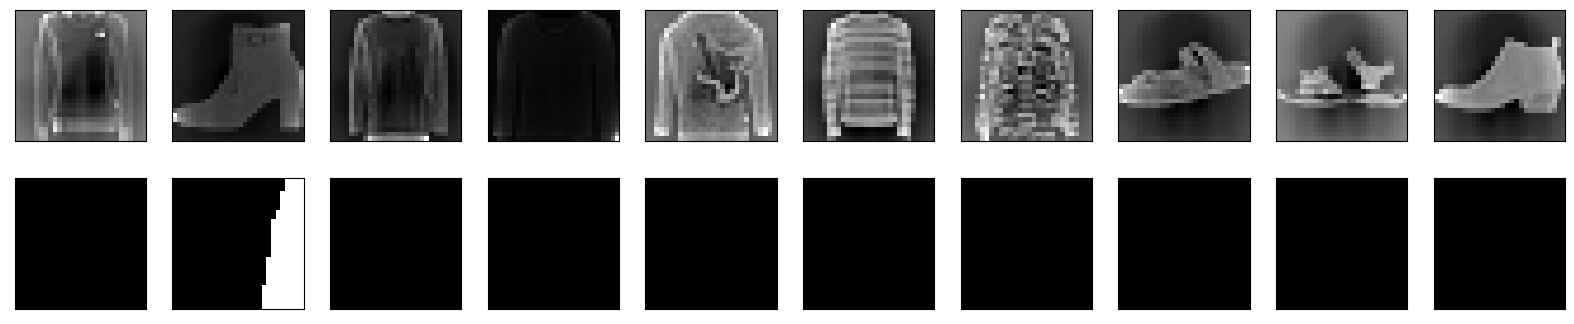

In [111]:
decoded_imgs = autoencoder.predict(x_val_values)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_val_values[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()